# Проект для «Викишоп» с BERT

## Описание проекта
Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

В нашем распоряжении набор данных с разметкой о токсичности правок.

**Цель** - построить модель, классифицирующую комментарии на позитивные и негативные.

**Тип задачи** - бинарная классификация.

**Целевая метрика** - *F1*.

**Целевое значение метрики *F1*** - не менее 0.75. 

**Описание данных**


## Описание данных
Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#Импорт-необходимых-модулей" data-toc-modified-id="Импорт-необходимых-модулей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Импорт необходимых модулей</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Токенизация-и-вектроизация" data-toc-modified-id="Токенизация-и-вектроизация-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Токенизация и вектроизация</a></span></li><li><span><a href="#Деление-на-обучающую-и-тестовую-выборки" data-toc-modified-id="Деление-на-обучающую-и-тестовую-выборки-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Деление на обучающую и тестовую выборки</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модели-с-параметрами-по-умолчанию" data-toc-modified-id="Модели-с-параметрами-по-умолчанию-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Модели с параметрами по умолчанию</a></span></li><li><span><a href="#Подбор-гиперпараметров-модели" data-toc-modified-id="Подбор-гиперпараметров-модели-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Подбор гиперпараметров модели</a></span></li><li><span><a href="#Подбор-порога-классификации" data-toc-modified-id="Подбор-порога-классификации-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Подбор порога классификации</a></span></li></ul></li><li><span><a href="#Проверка-на-тестовой-выборке" data-toc-modified-id="Проверка-на-тестовой-выборке-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Проверка на тестовой выборке</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Импорт необходимых модулей

In [1]:
# Чтобы предотвратить появление ошибки 
# TypeError: Descriptors cannot not be created directly 
# при загрузке Bert, установим следующий пакет

!pip install protobuf==3.20.*

In [2]:
import joblib
from joblib import Parallel, delayed
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, train_test_split
from sklearn.svm import SVC
import torch
import transformers

BATCH_SIZE = 40
SAMPLED_SIZE = 20000
MAX_TOKENS = 150

CV = 10
N_JOBS = -1
SEED = 42

%matplotlib inline

## Подготовка

### Загрузка данных

Загрузим данные и выведем первые 5 строк таблицы.

In [3]:
try:
    data = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
except FileNotFoundError:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=0)
    
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Выведем общую информацию о датафрейме.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Посмотрим какая доля наблюдений относится к положительному классу.

In [5]:
print(f'Доля токсичных комментариев: {data.toxic.mean():.2%}')

Доля токсичных комментариев: 10.16%


Наблюдается дисбаланс классов.

### Токенизация и вектроизация

Для токенизации и получения векторных представлений текстов будем использовать предобученную модель `BERT`, адаптированную для токсичных комментариев (`unitary/toxic-bert`).

Обработка данных с её помощью может занимать очень много времени, поэтому возьмём случайную стратифицированную выборку из полного датасета (20000 записей) и далее будем работать с ней. 

Проверим дисбаланс классов в полученной выборке.

In [6]:
sampled_data, _ = train_test_split(data, 
                                   train_size=SAMPLED_SIZE, 
                                   random_state=SEED, 
                                   stratify=data.toxic,
                                  )

del data
print(f'Доля токсичных комментариев: {sampled_data.toxic.mean():.2%}')

Доля токсичных комментариев: 10.16%


Выведем размер получившейся таблицы.

In [7]:
sampled_data.shape

(20000, 2)

Дисбаланс классов такойже как и в полном наборе данных. Загрузим предобученную модель и токенизатор.

In [7]:
pretrained_weights = 'unitary/toxic-bert'
model = transformers.BertModel.from_pretrained(pretrained_weights)
tokenizer = transformers.BertTokenizer.from_pretrained(pretrained_weights)

2023-03-23 15:03:53.167465: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-23 15:03:53.167498: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Выполним токенизацию и преобразуем тексты в номера токенов из словаря. 

Максимальное количество токенов, которые может обработать `BERT` равно 512. В данных есть комментарии, которые после разбивки на токены превысят это значение, и `BERT` не сможет работать с такими данными, поэтому количество токенов придётся ограничить. Оставлять максимальное количество токенов равным 512 не имеет смысла, так как это сильно увеличит время обработки данных, а полученный результат будет состоять в основном из нулей. Чтобы сократить время обработки и используемую память, ограничим количество токенов до 150.

Для ускорения расчётов также будем распараллеливать их с помощью `joblib`.

In [8]:
def encode(data):
    '''Преобразует батч исходных текстов в батч эмбедингов.'''
    
    tokenize = lambda x: tokenizer.encode(x, 
                                          add_special_tokens=True, 
                                          max_length=MAX_TOKENS, 
                                          truncation=True,
                                          padding='max_length',
                                         )
                                 
    
    tokenized = data.apply(tokenize).to_numpy().tolist()
    tokenized = np.array(tokenized)
    
    attention_mask = np.where(tokenized != 0, 1, 0)
    
    tokenized = torch.LongTensor(tokenized)
    attention_mask = torch.LongTensor(attention_mask)
    
    
    with torch.no_grad():
        embeddings = model(tokenized, attention_mask=attention_mask)
        
    embeddings = embeddings[0][:,0,:].numpy()
    
    
    return embeddings

Сформируем матрицу признаков.

In [9]:
X = Parallel(n_jobs=N_JOBS,
             verbose=0,
            )(delayed(encode)
              (sampled_data.text.iloc[BATCH_SIZE * i: BATCH_SIZE * (i + 1)]) 
              for i 
              in range(len(sampled_data) // BATCH_SIZE)
             )

X = np.concatenate(X)

2023-03-23 15:04:02.051659: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-23 15:04:02.051695: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-23 15:04:03.045592: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-23 15:04:03.045630: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-23 15:04:04.014609: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or dire

Матрица признаков подготовлена. Подготовим вектор целевой переменной.

In [10]:
y = sampled_data.toxic.to_numpy()

### Деление на обучающую и тестовую выборки

Разделим подготовленные данные на обучающую и тестовую выборки.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

## Обучение

### Модели с параметрами по умолчанию
Обучим и сравним несколько моделей с параметрами по умолчанию и оценим целевую метрику для них. Установим только параметр `class_weight='balanced'`, так как в данных наблюдается сильный дисбаланс классов.

In [12]:
#Датафреймы в которые будут записаны метрики моделей:
scores = pd.DataFrame(columns=['classifier', 'f1_cv', 'f1_train'])
classifier_scores = pd.DataFrame(columns=['classifier', 'f1_cv', 'f1_train'])

Обучим и оценим логистическую регрессию

In [13]:
logistic_regr = LogisticRegression(solver='liblinear',
                                   class_weight='balanced'
                                  )

classifier_scores['f1_cv'] = cross_val_score(
    estimator=logistic_regr,
    X=X_train,
    y=y_train,
    scoring='f1',
    cv=CV,
    n_jobs=N_JOBS,
)
classifier_scores['classifier'] = 'LogisticRegression'

y_pred = logistic_regr.fit(X_train, y_train).predict(X_train)
classifier_scores['f1_train'] = f1_score(y_pred, y_train)

scores = scores.append(classifier_scores, ignore_index=True)

Обучим и оценим SVC

In [14]:
scv = SVC(class_weight='balanced')

classifier_scores['f1_cv'] = cross_val_score(
    estimator=scv,
    X=X_train,
    y=y_train,
    scoring='f1',
    cv=CV,
    n_jobs=N_JOBS,
)
classifier_scores['classifier'] = 'SVC'

y_pred = scv.fit(X_train, y_train).predict(X_train)
classifier_scores['f1_train'] = f1_score(y_pred, y_train)

scores = scores.append(classifier_scores, ignore_index=True)

Обучим и оценим случайный лес

In [15]:
random_forest = RandomForestClassifier(n_jobs=N_JOBS, class_weight='balanced')

classifier_scores['f1_cv'] = cross_val_score(
    estimator=random_forest,
    X=X_train,
    y=y_train,
    scoring='f1',
    cv=CV,
    n_jobs=N_JOBS,
)
classifier_scores['classifier'] = 'RandomForestClassifier'

y_pred = random_forest.fit(X_train, y_train).predict(X_train)
classifier_scores['f1_train'] = f1_score(y_pred, y_train)

scores = scores.append(classifier_scores, ignore_index=True)

Обучим и оценим LightGBM

In [16]:
lgbm = LGBMClassifier(class_weight='balanced')

classifier_scores['f1_cv'] = cross_val_score(
    estimator=lgbm,
    X=X_train,
    y=y_train,
    scoring='f1',
    cv=CV,
    n_jobs=N_JOBS,
)
classifier_scores['classifier'] = 'LGBMClassifier'

y_pred = lgbm.fit(X_train, y_train).predict(X_train)
classifier_scores['f1_train'] = f1_score(y_pred, y_train)

scores = scores.append(classifier_scores, ignore_index=True)

Сравним результаты

In [17]:
def score_box_plot(score, rot=45):
    '''Печатает диаграммы размаха целевой метрики.'''
    
    fig, ax = plt.subplots(1, 1)

    ax = sns.scatterplot(data=score, 
                        x='classifier', 
                        y='f1_train', 
                        markers='X', 
                        label='f1 на тренировочном наборе',
                        ax=ax
                       )

    ax = sns.boxplot(data=score, 
                     x='classifier', 
                     y='f1_cv', 
                     color='white', 
                     showmeans=True,
                     ax=ax
                    )

    ax.tick_params(axis='x', rotation=rot)
    ax.set_xlabel('Классификатор')
    ax.set_ylabel('f1')
    ax.set_title(f'Значения метрики f1 по результатм\nкросс-валидации для разных классификаторов')
    ax.legend(loc='lower right')
    
    ax.grid()

    plt.show()

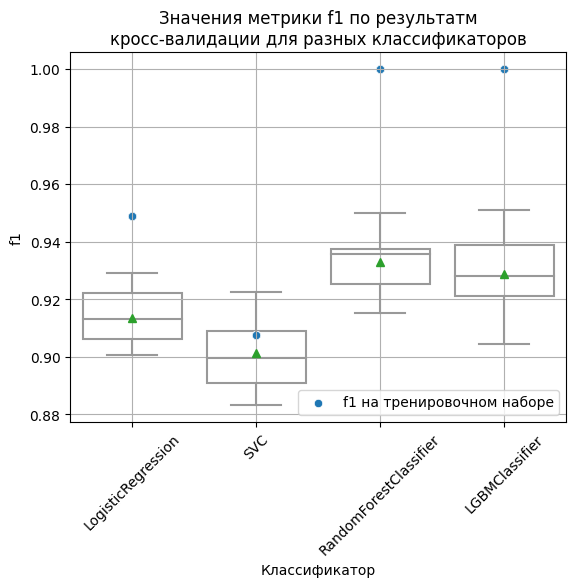

In [18]:
score_box_plot(scores)

Все модели показали очень хорошие результаты, значение метрики *F1* значительно превысило целевое.

`RandomForestClassifier` и `LGBMClasscifier` как-будто демонстрируют  переобучение, они же показали лучший результат.

Попоробуем подобрать гиперпараметры логистической регресси и `LGBMClasscifier`.

### Подбор гиперпараметров модели

In [19]:
scores = pd.DataFrame(columns=['classifier', 'f1_cv', 'f1_train'])
classifier_scores = pd.DataFrame(columns=['classifier', 'f1_cv', 'f1_train'])

Подберём гиперпараметры для логистической регрессии.

In [20]:
params = {'C': [1.0, 1.7, 1.75, 1.8]}

grid_search = GridSearchCV(estimator=logistic_regr,
                           param_grid=params,
                           scoring='f1',
                           n_jobs=N_JOBS,
                           cv=CV,
                           verbose=1,
                          )

grid_search.fit(X_train, y_train)

best_logistic_regr = grid_search.best_estimator_
print(f'Лучшие параметры: {grid_search.best_params_}')


classifier_scores['f1_cv'] = cross_val_score(
    estimator=best_logistic_regr,
    X=X_train,
    y=y_train,
    scoring='f1',
    cv=CV,
    n_jobs=N_JOBS,
)
classifier_scores['classifier'] = 'best_LogisticRegression'

y_pred = best_logistic_regr.predict(X_train)
classifier_scores['f1_train'] = f1_score(y_pred, y_train)

scores = scores.append(classifier_scores, ignore_index=True)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Лучшие параметры: {'C': 1.75}


Подберём гиперпараметры для LightGBM.

In [21]:
params = {
    'num_leaves': [11, 21, 31],
    'n_estimators': [50, 100, 150],
    'reg_lambda': [0, 0.25, 0.5]
}

grid_search = GridSearchCV(estimator=lgbm,
                           param_grid=params,
                           scoring='f1',
                           n_jobs=N_JOBS,
                           cv=CV,
                           verbose=1,
                          )

grid_search.fit(X_train, y_train)

best_lgbm = grid_search.best_estimator_
print(f'Лучшие параметры: {grid_search.best_params_}')


classifier_scores['f1_cv'] = cross_val_score(
    estimator=best_lgbm,
    X=X_train,
    y=y_train,
    scoring='f1',
    cv=CV,
    n_jobs=N_JOBS,
)
classifier_scores['classifier'] = 'best_LGBMClassifier'

y_pred = best_lgbm.predict(X_train)
classifier_scores['f1_train'] = f1_score(y_pred, y_train)

scores = scores.append(classifier_scores, ignore_index=True)

Fitting 10 folds for each of 27 candidates, totalling 270 fits
Лучшие параметры: {'n_estimators': 150, 'num_leaves': 31, 'reg_lambda': 0.5}


Сравним результаты

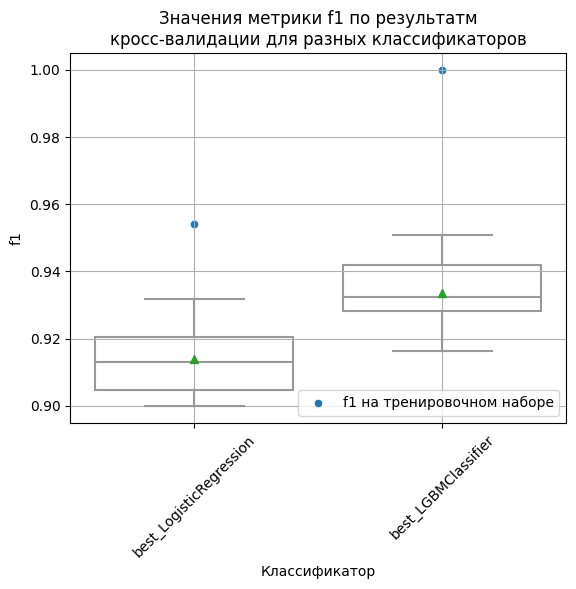

In [22]:
score_box_plot(scores)

Настройка гиперпараметров не оказала значительного влияния на результаты моделей, однако, снизила разброс результатов LGBMClassifier.

### Подбор порога классификации

Проверим можем ли мы улучшить значение целевой метрики, изменив порог классификации, для этого построим графики зависимости *F1* от этого порога. Начнём с логистической регрессии.

In [23]:
def eval_f1_threshold(estimator, X, y):
    pred_probs = cross_val_predict(estimator=estimator,
                                   X=X,
                                   y=y,
                                   cv=CV,
                                   n_jobs=N_JOBS,
                                   method='predict_proba'
                                  )

    scores = list()
    tresholds = np.linspace(0, 1, 200)

    for threshold in tresholds:
        y_pred = np.where(pred_probs[:, 1] < threshold, 0, 1)
        scores.append(f1_score(y_train, y_pred))

    max_ids = np.array(scores).argmax()

    plt.plot(tresholds, scores, label='F1')
    plt.plot(tresholds[max_ids], scores[max_ids], 'or', label='Максимальное значение F1')
    plt.ylim([0, 1])

    plt.title('Зависимость F1 от порога классификации')
    plt.xlabel('Порог классификации')
    plt.ylabel('F1')

    plt.grid()
    plt.legend()

    plt.show()
    
    print(f'Порог классификации показавший лучшее значение F1: {tresholds[max_ids]:.4f};')
    print(f'Лучшее значение F1: {scores[max_ids]:.4f}.') 

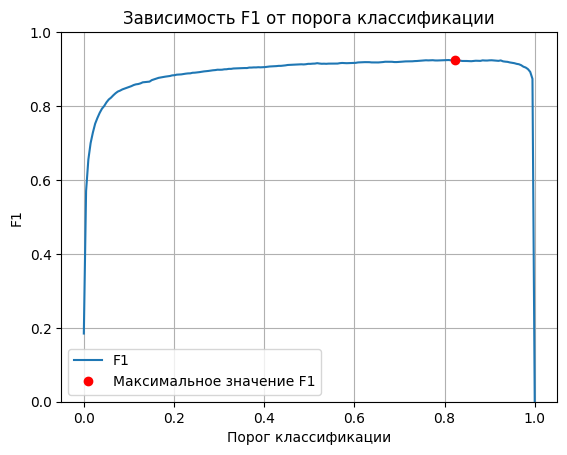

Порог классификации показавший лучшее значение F1: 0.8241;
Лучшее значение F1: 0.9246.


In [24]:
eval_f1_threshold(best_logistic_regr, X_train, y_train)

Оценим ту же зависимость для LightGBM.

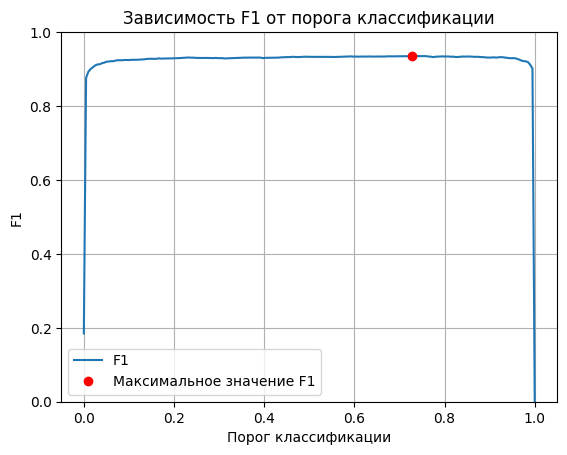

Порог классификации показавший лучшее значение F1: 0.7286;
Лучшее значение F1: 0.9351.


In [25]:
eval_f1_threshold(best_lgbm, X_train, y_train)

Значение *F1* слабо зависит от значения порога классификации, а для `LGBMClassifier` оно практически не меняется, поэтому не будем модифицировать модели и выполним проверку `LGBMClassifier` на тестовой выборке.

## Проверка на тестовой выборке

Проверим `LGBMClassifier` на тестовой выборке.

In [26]:
y_pred = best_lgbm.predict(X_test)
print(f'F1 лучшей модели на тестовой выборке: {f1_score(y_pred, y_test):.4f}')

F1 лучшей модели на тестовой выборке: 0.9428


## Выводы

- Использование `unitary/toxic-bert` позволяет получить отличные результаты даже с логистической регрессией;
- целесообразно сокращение количества токенов, отправляемых на вход `BERT`: значение целевой метрики незначительно снижается, а скорость обработки возрастает в разы;
- `BERT` не требует предварительной очистки текстов от спецсимволов и стоп-слов;
- полученное значение целевой метрики определяет подготовка данных для классификатора, а настройка его гиперпараметров практически ничего не меняет;
- изменение порога классификации также не приводит к существенному улучшению целевой метрики.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны